In [287]:
!python3 --version

Python 3.7.3


In [288]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [289]:
def dataframe_to_data(raw):
    labels = raw['label']
    raw.drop('label', axis=1, inplace=True)

    return raw.values, labels.values

In [290]:
data_raw = pd.read_csv('dataset/sign_mnist_train.csv', sep=",")
data, labels = dataframe_to_data(data_raw)
print("data:", len(data))

test_validation_data_raw = pd.read_csv('dataset/sign_mnist_test.csv', sep=",")

n = len(test_validation_data_raw)
test_data_raw       = test_validation_data_raw.loc[:n//2, :]
validation_data_raw = test_validation_data_raw.loc[n//2:, :]

test_data, labels_test = dataframe_to_data(test_data_raw)
print("test:", len(test_data))

validation_data, labels_validation = dataframe_to_data(validation_data_raw)
print("validation:", len(validation_data))


data: 27455
test: 3587
validation: 3586


In [291]:
IMAGE_SIZE = 28

In [292]:
def num_to_letter(num: int) -> str:
    start = ord('a')
    return chr(num + start)

examples = [num_to_letter(i) for i in range(26)]
print(examples)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [293]:
from ipywidgets import interact

@interact(sample = (0, len(data)))
def show_image_dataset(sample):
    info, label = data[sample], labels[sample]
    pixels = info.reshape(IMAGE_SIZE, IMAGE_SIZE)

    _, ax = plt.subplots(figsize=(3.5, 3.5))
    sns.heatmap(data=pixels, cmap="YlGnBu", ax=ax)
    plt.title(num_to_letter(label), fontsize=30, color="#00008b")
    
    plt.show()

interactive(children=(IntSlider(value=13727, description='sample', max=27455), Output()), _dom_classes=('widge…

In [294]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [295]:
data = [pic.reshape(1, IMAGE_SIZE, IMAGE_SIZE) for pic in data]
validation_data = [pic.reshape(1, IMAGE_SIZE, IMAGE_SIZE) for pic in validation_data]
test_data = [pic.reshape(1, IMAGE_SIZE, IMAGE_SIZE) for pic in test_data]

x                        = torch.FloatTensor(data)
y                        = torch.LongTensor(labels.tolist())

validation_data_formated = torch.FloatTensor(validation_data)
validation_labels        = torch.LongTensor(labels_validation.tolist())

test_data_formated       = torch.FloatTensor(test_data)
test_labels              = torch.LongTensor(labels_test.tolist())

In [296]:
train_on_gpu = torch.cuda.is_available()
print(f"train_on_gpu = {train_on_gpu}")

train_on_gpu = False


In [297]:
epochs = 15
batch_size = 64
learning_rate = 0.001

In [298]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()

        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1    = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        self.pool1    = nn.MaxPool2d(2)
        
        # convolutional layer (sees 10x tensor)
        self.conv2    = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3)
        self.pool2    = nn.MaxPool2d(2)
        
        # convolutional layer (sees 20x tensor)
        self.conv3    = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3) 
        self.dropout1 = nn.Dropout2d()
        
        self.fc3      = nn.Linear(30 * 3 * 3, 256) 
        self.fc4      = nn.Linear(256, 26)
        
        self.softmax  = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = x.view(-1, self.fc3.in_features) 

        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return self.softmax(x)
    

    def evaluate(self, x):
      output = self(x)
      return torch.max(output.data, 1)[1]  


    def step_train(self, optimizer, loss_fn, x, y):
        x = Variable(x)
        y = Variable(y)
        if train_on_gpu: x, y = x.cuda(), y.cuda()
        
        optimizer.zero_grad()
        loss = loss_fn(self(x), y)
        loss.backward()
        optimizer.step()

        return loss.item()

          
    def accuracy(self, predictions, labels) -> float:  
        correct = 0
        for prediction, label in zip(predictions, labels):
            if prediction == label: correct += 1
        
        return correct / len(predictions)

In [299]:
torch.manual_seed(0)
np.random.seed(0)
net = Network()
print(net)

Network(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (fc3): Linear(in_features=270, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=26, bias=True)
  (softmax): LogSoftmax()
)


In [300]:
optimizer = optim.SGD(net.parameters(), learning_rate, momentum=0.7)
loss_fn = nn.CrossEntropyLoss()

In [301]:
from statistics import mean 

valid_loss_min = np.Inf
train_losses, valid_losses = [], [] 
for epoch in range(epochs):
    # train the model
    net.train()
    train_loss = []
    for i in range(0, x.shape[0], batch_size):
        loss = net.step_train(optimizer, loss_fn, x[i : i + batch_size], y[i : i + batch_size])
        train_loss.append(loss)

    train_loss = mean(train_loss)    
    train_losses.append(train_loss)

    # validate the model
    net.eval()
    valid_loss = net.step_train(optimizer, loss_fn, validation_data_formated, validation_labels)
    valid_losses.append(valid_loss)

    print(f'Epoch: {epoch + 1} \t', end="")        
    print(f'Training Loss: {round(train_loss, 6)} \t', end="")  
    print(f'Validation Loss: {round(valid_loss, 6)}')

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        before, after = round(valid_loss_min, 6), round(valid_loss, 6)
        print(f'Validation loss min: ({before} --> {after}). \nSaving model')

        torch.save(net.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss

    print()

Epoch: 1 	Training Loss: 2.928606 	Validation Loss: 2.629726
Validation loss min: (inf --> 2.629726). 
Saving model

Epoch: 2 	Training Loss: 2.262161 	Validation Loss: 2.017434
Validation loss min: (2.629726 --> 2.017434). 
Saving model

Epoch: 3 	Training Loss: 1.694981 	Validation Loss: 1.546543
Validation loss min: (2.017434 --> 1.546543). 
Saving model

Epoch: 4 	Training Loss: 1.340563 	Validation Loss: 1.428787
Validation loss min: (1.546543 --> 1.428787). 
Saving model

Epoch: 5 	Training Loss: 1.134665 	Validation Loss: 1.258435
Validation loss min: (1.428787 --> 1.258435). 
Saving model

Epoch: 6 	Training Loss: 0.95913 	Validation Loss: 1.012112
Validation loss min: (1.258435 --> 1.012112). 
Saving model

Epoch: 7 	Training Loss: 0.753655 	Validation Loss: 0.825123
Validation loss min: (1.012112 --> 0.825123). 
Saving model

Epoch: 8 	Training Loss: 0.567916 	Validation Loss: 0.727216
Validation loss min: (0.825123 --> 0.727216). 
Saving model

Epoch: 9 	Training Loss: 0.498

In [307]:
net.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

Text(0.5, 1.0, 'Losses')

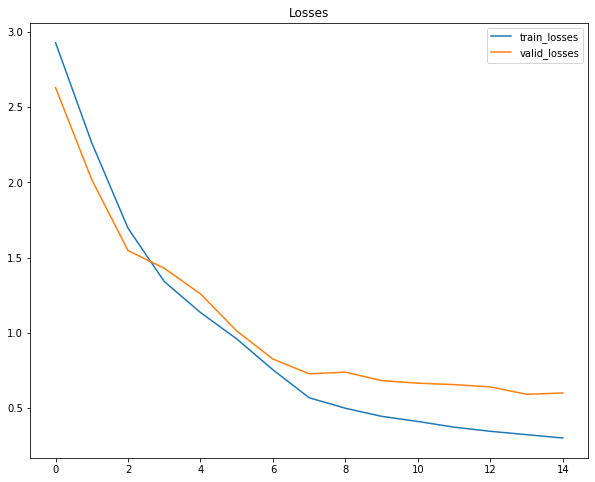

In [308]:
%matplotlib inline

plt.figure(figsize=(10,8))
plt.plot(train_losses, label="train_losses")
plt.plot(valid_losses, label="valid_losses")
plt.legend()
plt.title("Losses")

In [309]:
net.eval()

Network(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (fc3): Linear(in_features=270, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=26, bias=True)
  (softmax): LogSoftmax()
)

In [310]:
@interact(sample = (0, len(test_data)))
def show_image_dataset(sample):
    info, label  = test_data[sample], labels_test[sample]
    pixels       = info.reshape(IMAGE_SIZE, IMAGE_SIZE)

    input_pixels    = info.reshape(1, IMAGE_SIZE, IMAGE_SIZE).tolist()
    predicted_label = net.evaluate(torch.FloatTensor([input_pixels]))
    
    _, ax = plt.subplots(figsize=(3.5, 3.5))
    sns.heatmap(data=pixels, cmap="YlGnBu", ax=ax)

    actual    = f"{num_to_letter(label)} ⟵ actual"
    predicted = f"{num_to_letter(predicted_label)} ⟵ predicted"
    plt.title(actual + "\n" + predicted, fontsize=20, color="#00008b", loc="left")

    plt.show()

interactive(children=(IntSlider(value=1793, description='sample', max=3587), Output()), _dom_classes=('widget-…

In [311]:
prediction = net.evaluate(Variable(test_data_formated))
accuracy = net.accuracy(prediction, test_labels)

n = len(prediction)
correct = int(n * accuracy)
print(f"Correct predictions: {correct} / {n}: ", end="")
print(f"{round(accuracy, 6)}")

Correct predictions: 2966 / 3587: 0.826875
